In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Retreive data from cloud

In [2]:
#import mysql.connector
#conn = mysql.connector.connect(
#    host='database.cbg3amltio47.us-east-2.rds.amazonaws.com', port=3306,
#    user='admin', password='adminadmin',
#    database='mydb')
#crsr = conn.cursor()

In [3]:
#query = 'SELECT * FROM mydb.`Maison _Appartement`;'

In [4]:
#results = pd.read_sql_query(query, conn)
#results.to_csv("house_prices.csv", index=False)

# Retreive data from csv

In [5]:
results = pd.read_csv("./database/house_prices.csv")

# Data Exploration

In [6]:
df_init = results.copy()

In [7]:
df_init.head(5)

,id,type_de_bien,année,nb_de_pieces,surface,ville,prix
0,1,appartement,1970,2,47,ARCACHON,440000
1,19,maison,8,4,282,LUDON MEDOC,664650
2,20,maison,4,3,140,ARCACHON,787500
3,21,appartement,1994,2,41,BORDEAUX,145800
4,22,maison,9,4,360,PESSAC,756000


In [8]:
#import pandas_profiling
#ReportFullTrain = df_train_full.profile_report(title='Train full Profile Report')
#ReportFullTrain.to_file(output_file="HP-train-full-Report.html")

In [9]:
df_init['ville'] = df_init['ville'].str.strip()
df_init.head(5)

,id,type_de_bien,année,nb_de_pieces,surface,ville,prix
0,1,appartement,1970,2,47,ARCACHON,440000
1,19,maison,8,4,282,LUDON MEDOC,664650
2,20,maison,4,3,140,ARCACHON,787500
3,21,appartement,1994,2,41,BORDEAUX,145800
4,22,maison,9,4,360,PESSAC,756000


In [10]:
y_train_full = df_init['prix'].copy()
X_train_full = df_init.drop(['id','prix'], axis =1).copy()


# Output

(<matplotlib.axes._subplots.AxesSubplot at 0x28fc54e7848>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28fc54e7848>)

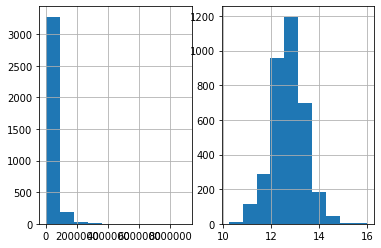

In [11]:
y_train_log =np.log1p(y_train_full)
plt.subplot(1,2,1), y_train_full.hist()
plt.subplot(1,2,2), y_train_log.hist()

# Outliers

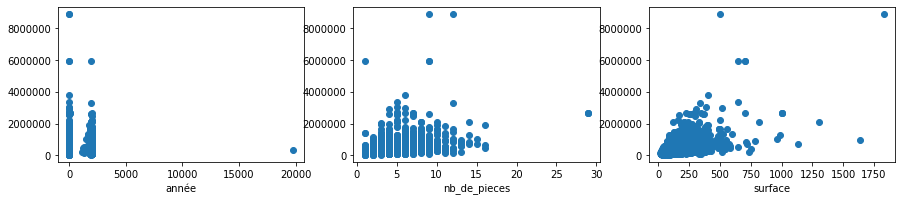

In [12]:
#outliers - numerical columns.
col_num = ['année','nb_de_pieces','surface']
fig=plt.figure(figsize=(15,20))
i =1 
for c in col_num:
    ax=fig.add_subplot(6,3,i)
    ax.scatter(x = X_train_full[c], y=y_train_full)
    ax.set_xlabel(c)
    i=i+1

## Année

In [13]:
dfx = df_init[df_init['année']<1000]
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1818 entries, 1 to 3503
Data columns (total 7 columns):
id              1818 non-null int64
type_de_bien    1818 non-null object
année           1818 non-null int64
nb_de_pieces    1818 non-null int64
surface         1818 non-null int64
ville           1818 non-null object
prix            1818 non-null int64
dtypes: int64(5), object(2)
memory usage: 113.6+ KB


In [14]:
 #df_ = df_null.sort_values(by='Null_Count',ascending = False)

## Categorical feature

In [15]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

In [16]:
from sklearn.preprocessing import StandardScaler

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [17]:
from sklearn.compose import ColumnTransformer
cat_columns=['type_de_bien', 'ville']
num_columns=['année','nb_de_pieces','surface']

preprocess_pipe = ColumnTransformer([
    ('cat', categorical_pipe, cat_columns),
    ('num', numeric_pipe, num_columns)])


In [18]:
import xgboost as xgb

xgbReg_model = xgb.XGBRegressor()

full_pipe = Pipeline(
    [('pp', preprocess_pipe),
    ('xgb', xgbReg_model)]
)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = 0.2)

In [20]:

full_pipe.fit(X_train_full, y_train_full)


[22:00:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Utilisateur\Anaconda3\envs\HPv2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Pipeline(memory=None,
         steps=[('pp',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                                                

In [21]:
y_train_pred = full_pipe.predict(X_train)

In [22]:
y_val_pred = full_pipe.predict(X_val)

In [23]:
import numpy as np
from sklearn import metrics
print()
print('XGBOOST')
print ('Results on train')
print('RMSLE : ', np.sqrt(metrics.mean_squared_log_error(y_train, y_train_pred)))
print('MAE : ', metrics.mean_absolute_error(y_train, y_train_pred))
print()

print ('Results on val')
print('RMSLE : ', np.sqrt(metrics.mean_squared_log_error(y_val, y_val_pred)))
print('MAE : ', metrics.mean_absolute_error(y_val, y_val_pred))
print()


XGBOOST
Results on train
RMSLE :  0.409575860589016
MAE :  124034.36069565799

Results on val
RMSLE :  0.43386865037507566
MAE :  120506.24477309201



In [24]:
# save the model to disk
import pickle
filename = 'HPv2.sav'
pickle.dump(full_pipe, open(filename, 'wb'))


In [25]:
X_prev = {"type_de_bien":["appartement"],
        "année":[2008],
        "nb_de_pieces":[2],
        "surface":[140],
        "ville":["BORDEAUX"]}
X_prev = pd.DataFrame(X_prev)
X_prev

,type_de_bien,année,nb_de_pieces,surface,ville
0,appartement,2008,2,140,BORDEAUX


In [26]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_prev = loaded_model.predict(X_prev)
print("The price prevision is : ",y_prev[0])

[22:00:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The price prevision is :  649785.7
